c:\Users\DARSHAN PARMAR\.conda\envs\brats\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda

1. Random Prediction Test

Random Prediction Results:
--------------------------------------------------


c:\Users\DARSHAN PARMAR\.conda\envs\brats\lib\site-packages\monai\utils\deprecate_utils.py:221: FutureWarning: monai.metrics.utils get_mask_edges:always_return_as_numpy: Argument `always_return_as_numpy` has been deprecated since version 1.5.0. It will be removed in version 1.7.0. The option is removed and the return type will always be equal to the input type.
  warn_deprecated(argname, msg, warning_category)
c:\Users\DARSHAN PARMAR\.conda\envs\brats\lib\site-packages\monai\metrics\utils.py:327: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\DARSHAN PARMAR\.conda\envs\brats\lib\site-packages\monai\metrics\utils.py:327: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\DARSHAN PARMAR\.conda\envs\brats\lib\site-packages\monai\metrics\utils.py:327: UserWarning: the ground truth of class 2 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\User

Composite Loss: 2.695878
DiceCE Loss: 1.855076
Tversky Loss: 0.899310
Surface Loss: 7.970613

Per-sample losses:
  Sample 0 Loss: 2.797569
  Sample 1 Loss: 2.594186

Normalized Class Weights:
  Sample 0:
    Background: 0.0000
    NETC: 0.9275
    SNFH: 0.9262
    ET: 1.0000
    RC: 1.0000
  Sample 1:
    Background: 0.0000
    NETC: 1.0000
    SNFH: 1.0000
    ET: 1.0000
    RC: 1.0000


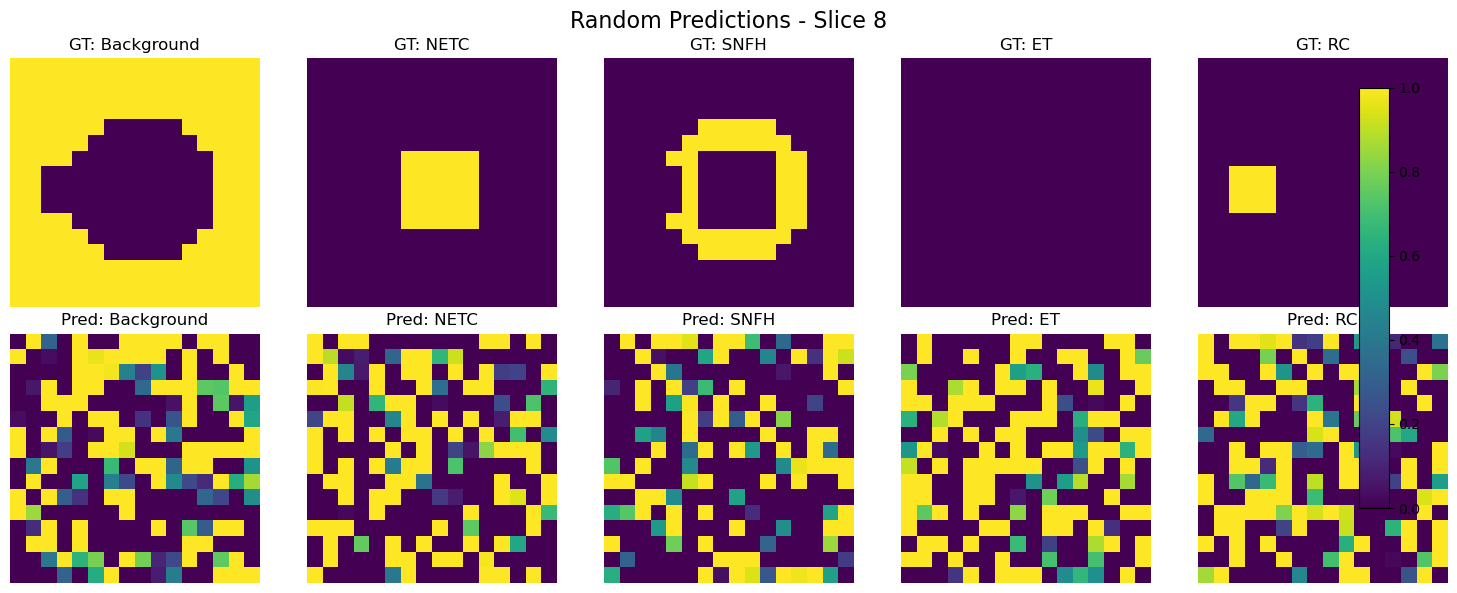


2. Noisy Prediction Test

Noisy Prediction Results:
--------------------------------------------------
Composite Loss: 0.741216
DiceCE Loss: 1.007089
Tversky Loss: 0.845950
Surface Loss: 0.000000

Per-sample losses:
  Sample 0 Loss: 0.741216
  Sample 1 Loss: 0.741216

Normalized Class Weights:
  Sample 0:
    Background: 0.0000
    NETC: 0.9275
    SNFH: 0.9262
    ET: 1.0000
    RC: 1.0000
  Sample 1:
    Background: 0.0000
    NETC: 1.0000
    SNFH: 1.0000
    ET: 1.0000
    RC: 1.0000


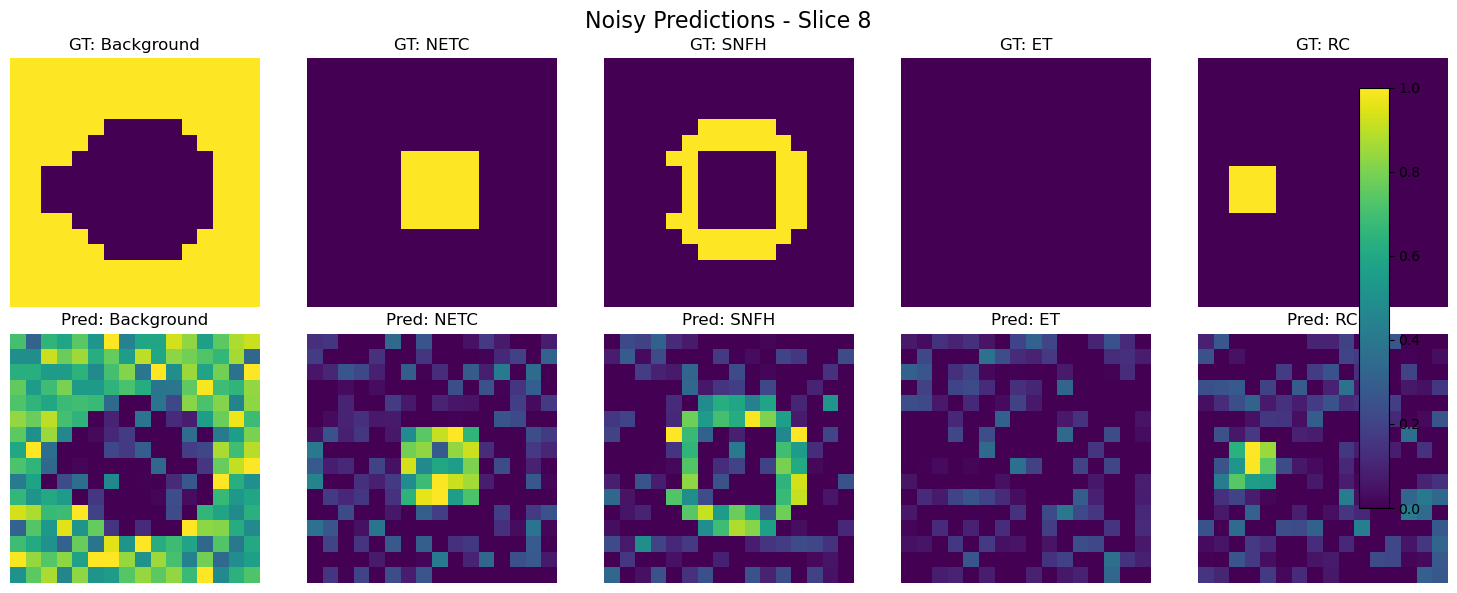


3. Identical Prediction Test

Identical Prediction Results:
--------------------------------------------------
Composite Loss: 0.661971
DiceCE Loss: 0.855500
Tversky Loss: 0.799429
Surface Loss: 0.000000

Per-sample losses:
  Sample 0 Loss: 0.661971
  Sample 1 Loss: 0.661971

Normalized Class Weights:
  Sample 0:
    Background: 0.0000
    NETC: 0.9275
    SNFH: 0.9262
    ET: 1.0000
    RC: 1.0000
  Sample 1:
    Background: 0.0000
    NETC: 1.0000
    SNFH: 1.0000
    ET: 1.0000
    RC: 1.0000


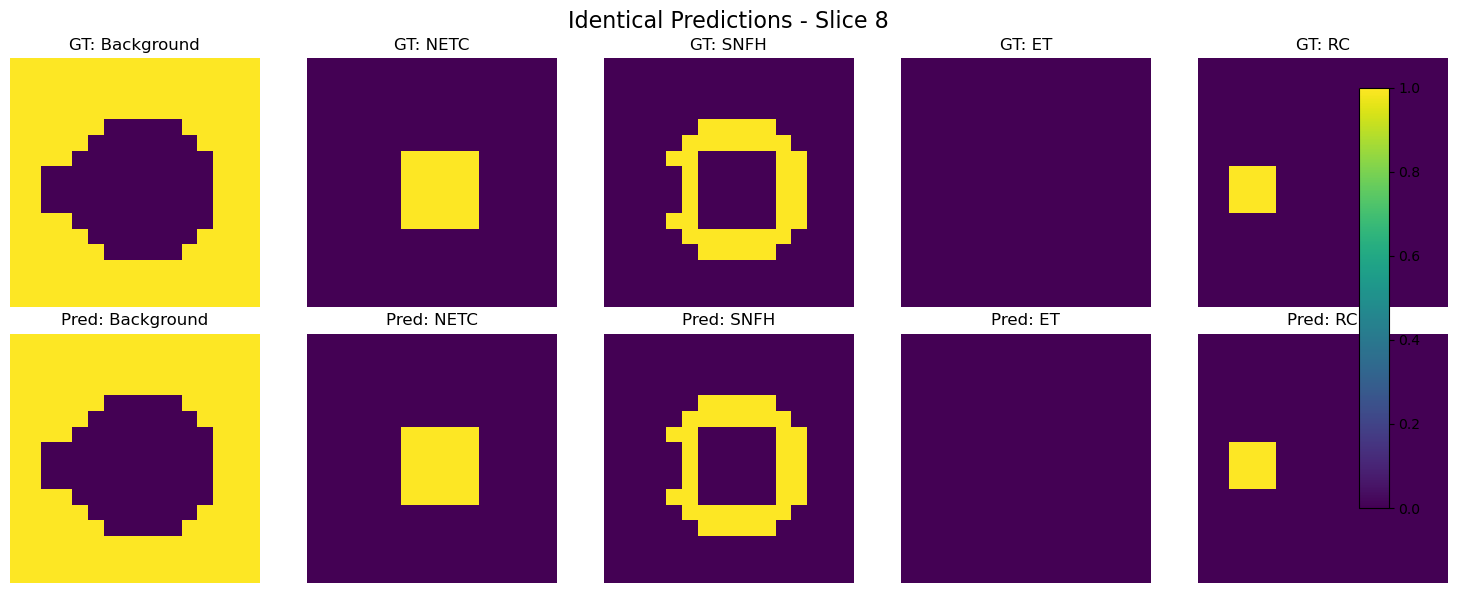

In [1]:
# Updated trail.py with device-consistent logic

import torch
import numpy as np
import matplotlib.pyplot as plt
from loss import VolumeAwareLoss
import torch.nn.functional as F
from monai.utils import set_determinism
import datetime

set_determinism(seed=42)

def create_sample_data(shape=(2, 5, 16, 16, 16)):
    batch_size, n_classes, d, h, w = shape
    ground_truth = torch.zeros((batch_size, d, h, w), dtype=torch.long)

    center = np.array([d//2, h//2, w//2])
    for i in range(d):
        for j in range(h):
            for k in range(w):
                if np.sum(np.square([i-center[0], j-center[1], k-center[2]])) < 9:
                    ground_truth[0, i, j, k] = 1

    for i in range(d):
        for j in range(h):
            for k in range(w):
                dist = np.sum(np.square([i-center[0], j-center[1], k-center[2]]))
                if 9 <= dist < 25:
                    ground_truth[0, i, j, k] = 2

    centers = [np.array([d//2-3, h//2-3, w//2]), np.array([d//2+3, h//2+3, w//2])]
    for center in centers:
        for i in range(d):
            for j in range(h):
                for k in range(w):
                    if np.sum(np.square([i-center[0], j-center[1], k-center[2]])) < 2:
                        ground_truth[0, i, j, k] = 3

    center = np.array([d//2, h//2, w//2-5])
    for i in range(d):
        for j in range(h):
            for k in range(w):
                if np.sum(np.square([i-center[0], j-center[1], k-center[2]])) < 4:
                    ground_truth[0, i, j, k] = 4

    center = np.array([d//3, h//3, w//3])
    for i in range(d):
        for j in range(h):
            for k in range(w):
                if np.sum(np.square([i-center[0], j-center[1], k-center[2]])) < 7:
                    ground_truth[1, i, j, k] = 1

    for i in range(d):
        for j in range(h):
            for k in range(w):
                dist = np.sum(np.square([i-center[0], j-center[1], k-center[2]]))
                if 7 <= dist < 20:
                    ground_truth[1, i, j, k] = 2

    centers = [np.array([d//4, h//4, w//4]), np.array([d//2, h//2, w//2])]
    for center in centers:
        for i in range(d):
            for j in range(h):
                for k in range(w):
                    if np.sum(np.square([i-center[0], j-center[1], k-center[2]])) < 2:
                        ground_truth[1, i, j, k] = 3

    center = np.array([2*d//3, 2*h//3, 2*w//3])
    for i in range(d):
        for j in range(h):
            for k in range(w):
                if np.sum(np.square([i-center[0], j-center[1], k-center[2]])) < 3:
                    ground_truth[1, i, j, k] = 4

    ground_truth_onehot = F.one_hot(ground_truth, n_classes).permute(0, 4, 1, 2, 3).float()
    return ground_truth, ground_truth_onehot

def create_predictions(ground_truth_onehot):
    batch_size, n_classes, d, h, w = ground_truth_onehot.shape
    random_logits = torch.randn((batch_size, n_classes, d, h, w), device=ground_truth_onehot.device) * 2
    random_pred = F.softmax(random_logits, dim=1)

    noise_level = 0.3
    noise = torch.randn_like(ground_truth_onehot) * noise_level
    noisy_pred = ground_truth_onehot + noise
    noisy_pred = torch.clamp(noisy_pred, 0, 1)
    noisy_pred = noisy_pred / noisy_pred.sum(dim=1, keepdim=True)

    identical_pred = ground_truth_onehot.clone()
    return random_logits, noisy_pred, identical_pred

def visualize_slices(gt, pred, title, slice_idx=None):
    batch_idx = 0
    if slice_idx is None:
        slice_idx = gt.shape[2] // 2

    n_classes = gt.shape[1]
    fig, axes = plt.subplots(2, n_classes, figsize=(15, 6))
    plt.suptitle(f"{title} - Slice {slice_idx}", fontsize=16)

    class_names = ["Background", "NETC", "SNFH", "ET", "RC"]
    for c in range(n_classes):
        axes[0, c].imshow(gt[batch_idx, c, slice_idx].cpu(), cmap='viridis', vmin=0, vmax=1)
        axes[0, c].set_title(f"GT: {class_names[c]}")
        axes[0, c].axis('off')

        im = axes[1, c].imshow(pred[batch_idx, c, slice_idx].cpu(), cmap='viridis', vmin=0, vmax=1)
        axes[1, c].set_title(f"Pred: {class_names[c]}")
        axes[1, c].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()

def compute_and_print_losses(loss_fn, pred, target, case_name):
    print(f"\n{case_name} Prediction Results:\n{'-' * 50}")
    loss_dict = loss_fn(pred, target)
    print(f"Composite Loss: {loss_dict['loss'].item():.6f}")
    print(f"DiceCE Loss: {loss_dict['dice_ce_loss'].item():.6f}")
    print(f"Tversky Loss: {loss_dict['tversky_loss'].item():.6f}")
    print(f"Surface Loss: {loss_dict['surface_loss'].item():.6f}")

    print("\nPer-sample losses:")
    for i, sample_loss in enumerate(loss_dict['per_sample_loss']):
        print(f"  Sample {i} Loss: {sample_loss.item():.6f}")

    print("\nNormalized Class Weights:")
    class_names = ["Background", "NETC", "SNFH", "ET", "RC"]
    for i, sample_weights in enumerate(loss_dict['normalized_weights']):
        print(f"  Sample {i}:")
        for c, weight in enumerate(sample_weights):
            print(f"    {class_names[c]}: {weight.item():.4f}")

    return loss_dict

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    gt, gt_onehot = create_sample_data()
    gt = gt.to(device)
    gt_onehot = gt_onehot.to(device)

    random_pred, noisy_pred, identical_pred = create_predictions(gt_onehot)

    loss_fn = VolumeAwareLoss(
        include_background=True,
        softmax=True,
        tversky_alpha=0.3,
        tversky_beta=0.7,
        class_weights=[1.0, 2.0, 1.5, 2.5, 1.5],
        baseline_volumes=[0.0, 500.0, 2000.0, 250.0, 300.0],
    ).to(device)

    print("\n1. Random Prediction Test")
    compute_and_print_losses(loss_fn, random_pred, gt_onehot, "Random")
    visualize_slices(gt_onehot, random_pred, "Random Predictions")

    print("\n2. Noisy Prediction Test")
    compute_and_print_losses(loss_fn, noisy_pred, gt_onehot, "Noisy")
    visualize_slices(gt_onehot, noisy_pred, "Noisy Predictions")

    print("\n3. Identical Prediction Test")
    compute_and_print_losses(loss_fn, identical_pred, gt_onehot, "Identical")
    visualize_slices(gt_onehot, identical_pred, "Identical Predictions")

if __name__ == "__main__":
    main()
